Dataset shape: (30000, 25)
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1      20000    2          2         1   24      2      2     -1     -1   
1   2     120000    2          2         2   26     -1      2      0      0   
2   3      90000    2          2         2   34      0      0      0      0   
3   4      50000    2          2         1   37      0      0      0      0   
4   5      50000    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...          0          0          0         0       689         0   
1  ...       3272       3455       3261         0      1000      1000   
2  ...      14331      14948      15549      1518      1500      1000   
3  ...      28314      28959      29547      2000      2019      1200   
4  ...      20940      19146      19131      2000     36681     10000   

   PAY_AMT4  PAY_AMT5  PAY_AMT6  default payment next month

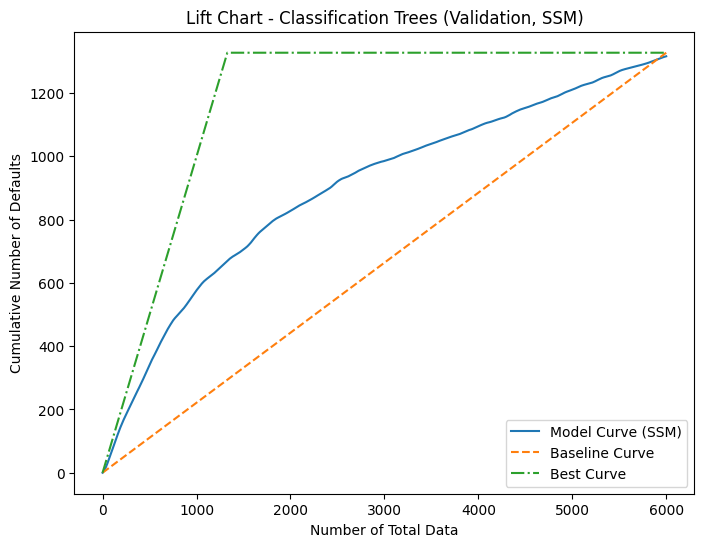

Training Error Rate: 0.17712499999999998
Training Area Ratio (with SSM): 0.4860953647409609

Table 1: Classification Accuracy
              Method  Error Rate (Training)  Error Rate (Validation)  Area Ratio (Training)  Area Ratio (Validation)
Classification Trees               0.177125                   0.1815               0.486095                 0.458323


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline

# --- 1. Data and Preparation ---
df = pd.read_csv('default_credit_score.csv', sep=',')
print("Dataset shape:", df.shape)
print(df.head())

if 'ID' in df.columns:
    df.drop('ID', axis=1, inplace=True)

X = df.drop("default payment next month", axis=1)
y = df["default payment next month"]

# --- 2. Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- 3. Build the Pruned Classification Tree Module ---
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('clf', DecisionTreeClassifier(max_depth=4, min_samples_split=200,
                                     min_samples_leaf=50, random_state=42))
])
pipeline.fit(X_train, y_train)

# --- 4. Predictions and Basic Evaluation ---
y_pred = pipeline.predict(X_test)
y_prob = pipeline.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
error_rate = 1 - accuracy

print("Validation Confusion Matrix:\n", cm)
print("\nValidation Classification Report:\n", report)
print("Validation Error Rate:", error_rate)

# --- 5. SSM Smoothing Function ---
def smooth_ssm(y_sorted, n=50):
    """
    Applies the Sorting Smoothing Method (SSM) using a moving average.

    Parameters:
        y_sorted (np.array): Sorted true labels (0 or 1) according to predicted probabilities.
        n (int): Half window size. The full window size is 2*n+1.

    Returns:
        smoothed (np.array): Smoothed probability estimates.
    """
    kernel = np.ones(2*n + 1) / (2*n + 1)
    smoothed = np.convolve(y_sorted, kernel, mode='same')
    return smoothed

# --- 6. Compute Lift Chart and Area Ratio with SSM ---
def compute_area_ratio(y_true, y_score, use_ssm=True, n=50):
    """
    Computes the area ratio based on the lift chart.

    If use_ssm is True, the true labels (ordered by predicted probability)
    are smoothed using the Sorting Smoothing Method (SSM) with window size 2*n+1.

    Parameters:
        y_true (array-like): True binary labels.
        y_score (array-like): Predicted probabilities for the positive class.
        use_ssm (bool): Whether to apply SSM smoothing.
        n (int): Half window size for SSM (full window = 2*n+1).

    Returns:
        area_ratio (float): Ratio of (area between model curve and baseline)
                            to (area between best curve and baseline).
        x (np.array): x-axis values (from 0 to N).
        cum_defaults (np.array): Cumulative defaults (model curve) starting at 0.
        D (float): Total number of defaults in y_true.
    """
    # Sort indices based on predicted probabilities (highest first)
    sorted_indices = np.argsort(y_score)[::-1]
    y_true_sorted = np.array(y_true)[sorted_indices].astype(float)

    # Apply SSM smoothing if requested
    if use_ssm:
        y_smoothed = smooth_ssm(y_true_sorted, n)
    else:
        y_smoothed = y_true_sorted

    # Compute cumulative sum starting from 0
    cum_defaults = np.insert(np.cumsum(y_smoothed), 0, 0)

    N = len(y_true)          # Total samples
    D = np.sum(y_true)       # Total defaults (using original labels)
    x = np.arange(0, N + 1)

    area_model = np.trapz(cum_defaults, x)

    area_baseline = 0.5 * D * N
    area_diff = area_model - area_baseline

    best_area_diff = 0.5 * D * (N - D)

    area_ratio = area_diff / best_area_diff if best_area_diff != 0 else None
    return area_ratio, x, cum_defaults, D

area_ratio_val, x_val, cum_defaults_val, D_val = compute_area_ratio(y_test, y_prob, use_ssm=True, n=50)
print("Validation Area Ratio (with SSM):", area_ratio_val)

def plot_lift_chart(x, cum_defaults, D, N):
    """
    Plots the lift chart showing the model curve (smoothed), baseline, and best curve.

    Parameters:
        x (np.array): x-axis values (from 0 to N).
        cum_defaults (np.array): Cumulative defaults from the model curve.
        D (float): Total number of defaults.
        N (int): Total number of records.
    """
    baseline = (D / N) * x
    best_curve = np.minimum(x, D)

    plt.figure(figsize=(8, 6))
    plt.plot(x, cum_defaults, label='Model Curve (SSM)')
    plt.plot(x, baseline, label='Baseline Curve', linestyle='--')
    plt.plot(x, best_curve, label='Best Curve', linestyle='-.')
    plt.xlabel("Number of Total Data")
    plt.ylabel("Cumulative Number of Defaults")
    plt.title("Lift Chart - Classification Trees (Validation, SSM)")
    plt.legend()
    plt.show()

N_val = len(y_test)
plot_lift_chart(x_val, cum_defaults_val, D_val, N_val)

# --- 7. Evaluate Training Data with SSM ---
y_train_pred = pipeline.predict(X_train)
y_train_prob = pipeline.predict_proba(X_train)[:, 1]
train_accuracy = accuracy_score(y_train, y_train_pred)
train_error_rate = 1 - train_accuracy
area_ratio_train, x_train, cum_defaults_train, D_train = compute_area_ratio(y_train, y_train_prob, use_ssm=True, n=50)

print("Training Error Rate:", train_error_rate)
print("Training Area Ratio (with SSM):", area_ratio_train)

# --- 8. Print the Values in a Table Format ---
results = {
    'Method': ['Classification Trees'],
    'Error Rate (Training)': [train_error_rate],
    'Error Rate (Validation)': [error_rate],
    'Area Ratio (Training)': [area_ratio_train],
    'Area Ratio (Validation)': [area_ratio_val]
}
results_df = pd.DataFrame(results)

print("\nTable 1: Classification Accuracy")
print(results_df.to_string(index=False))

<ipython-input-4-5528eb79443c>:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing', linestyle='--', color='red')
<ipython-input-4-5528eb79443c>:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing', linestyle='--', color='red')


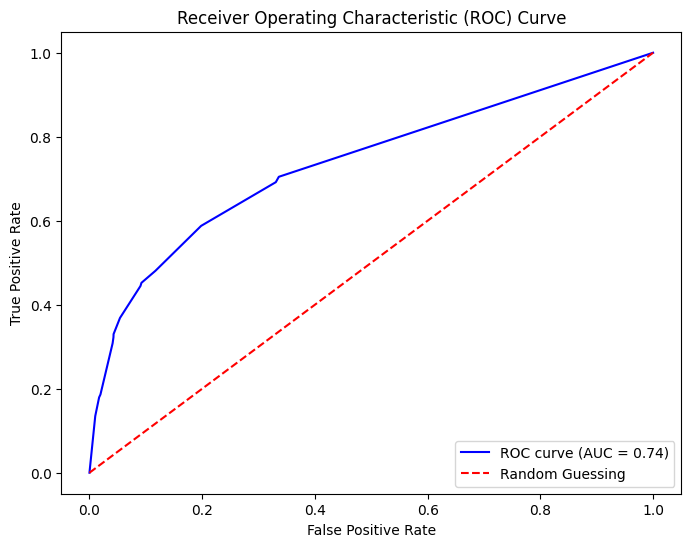

In [4]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing', linestyle='--', color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()